# Qrels Essential Documents Analysis

This notebook analyzes qrels data to identify:
- **Mandatory documents:** All base documents that have ANY segment in qrels (entire documents required)
- **Optional documents:** Documents with no segments in qrels (can be stratify sampled)
- **Distribution analysis:** Understanding document relevance frequency and patterns

## Key Understanding
- If ANY segment of a document is in qrels → include the ENTIRE document (all segments)
- All base documents with qrels segments are mandatory for evaluation
- Documents with no qrels segments can be added via stratified sampling

## Overview
- **Section 1:** Setup and Load Qrels
- **Section 2:** Mandatory Base Documents
- **Section 3:** Document Completeness Analysis
- **Section 4:** Distribution Analysis
- **Section 5:** Relevance Frequency Analysis
- **Section 6:** Query-Document Relationships
- **Section 7:** Mandatory vs Optional
- **Section 8:** KPI Calculation Requirements
- **Section 9:** Visualizations
- **Section 10:** Summary and Recommendations


## Section 1: Setup and Load Qrels


In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
from collections import Counter
from typing import Dict, Set

# Set style for better visualizations
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# Find project root (look for .data directory)
current_dir = Path.cwd()
project_root = current_dir
while project_root != project_root.parent:
    if (project_root / ".data").exists():
        break
    project_root = project_root.parent

DATA_DIR = project_root / ".data" / "trec_rag_assets"
OUTPUT_DIR = Path("data")
OUTPUT_DIR.mkdir(exist_ok=True)

QRELS_FILE = DATA_DIR / "qrels.rag24.test-umbrela-all.txt"

print(f"Data directory: .data/trec_rag_assets")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Qrels file: {QRELS_FILE.name}")


Data directory: .data/trec_rag_assets
Output directory: data
Qrels file: qrels.rag24.test-umbrela-all.txt


In [55]:
def parse_segment_id(segment_id: str) -> Dict:
    """
    Parse segment ID to extract metadata.
    Format: msmarco_v2.1_doc_XX_YYYYYYYY#Z_HASH
    Returns: base_doc_id, segment_number, domain
    """
    if "#" in segment_id:
        base_doc_id, rest = segment_id.split("#", 1)
        if "_" in rest:
            segment_num_str, _ = rest.split("_", 1)
        else:
            segment_num_str = rest
        segment_number = int(segment_num_str) if segment_num_str.isdigit() else -1
    else:
        base_doc_id = segment_id
        segment_number = -1
    
    # Extract domain (2-digit prefix after "doc_")
    # Format: msmarco_v2.1_doc_XX_YYYYYYYY
    domain_match = re.search(r'doc_(\d{2})_', base_doc_id)
    domain = domain_match.group(1) if domain_match else "unknown"
    
    return {
        "base_doc_id": base_doc_id,
        "segment_number": segment_number,
        "domain": domain
    }

# Test the parser
test_id = "msmarco_v2.1_doc_13_1647729865#1_3617399591"
parsed = parse_segment_id(test_id)
print(f"Test segment ID: {test_id}")
print(f"Parsed: {parsed}")


Test segment ID: msmarco_v2.1_doc_13_1647729865#1_3617399591
Parsed: {'base_doc_id': 'msmarco_v2.1_doc_13_1647729865', 'segment_number': 1, 'domain': '13'}


In [56]:
# Load qrels data
print(f"Loading qrels from: {QRELS_FILE.name}")

qrels_data = []
with open(QRELS_FILE, 'r') as f:
    for line in f:
        parts = line.strip().split()
        if len(parts) >= 4:
            query_id = parts[0]
            segment_id = parts[2]
            relevance = int(parts[3])
            
            # Parse segment ID
            parsed = parse_segment_id(segment_id)
            
            qrels_data.append({
                'query_id': query_id,
                'segment_id': segment_id,
                'relevance': relevance,
                'base_doc_id': parsed['base_doc_id'],
                'segment_number': parsed['segment_number'],
                'domain': parsed['domain']
            })

qrels_df = pd.DataFrame(qrels_data)

print(f"Loaded {len(qrels_df):,} qrels entries")
print(f"Unique segments: {qrels_df['segment_id'].nunique():,}")
print(f"Unique base documents: {qrels_df['base_doc_id'].nunique():,}")
print(f"Unique queries: {qrels_df['query_id'].nunique():,}")
print(f"\nFirst few rows:")
qrels_df.head(10)


Loading qrels from: qrels.rag24.test-umbrela-all.txt
Loaded 108,479 qrels entries
Unique segments: 107,132
Unique base documents: 60,166
Unique queries: 301

First few rows:


,query_id,segment_id,relevance,base_doc_id,segment_number,domain
0,2024-145979,msmarco_v2.1_doc_13_1647729865#1_3617399591,3,msmarco_v2.1_doc_13_1647729865,1,13
1,2024-145979,msmarco_v2.1_doc_01_523681915#0_449763684,2,msmarco_v2.1_doc_01_523681915,0,01
2,2024-145979,msmarco_v2.1_doc_13_1647729865#0_3617397938,3,msmarco_v2.1_doc_13_1647729865,0,13
3,2024-145979,msmarco_v2.1_doc_25_1148700328#0_2179512504,2,msmarco_v2.1_doc_25_1148700328,0,25
4,2024-145979,msmarco_v2.1_doc_25_1148700328#1_2179514079,2,msmarco_v2.1_doc_25_1148700328,1,25
5,2024-145979,msmarco_v2.1_doc_44_1043805224#2_2182641075,2,msmarco_v2.1_doc_44_1043805224,2,44
6,2024-145979,msmarco_v2.1_doc_25_771726319#2_1477545170,2,msmarco_v2.1_doc_25_771726319,2,25
7,2024-145979,msmarco_v2.1_doc_25_1148700328#3_2179517896,2,msmarco_v2.1_doc_25_1148700328,3,25
8,2024-145979,msmarco_v2.1_doc_13_1647729865#8_3617411267,2,msmarco_v2.1_doc_13_1647729865,8,13
9,2024-145979,msmarco_v2.1_doc_13_1647729865#3_3617403578,2,msmarco_v2.1_doc_13_1647729865,3,13


## Section 2: Mandatory Base Documents


In [57]:
# Identify ALL mandatory base documents
# Rule: If ANY segment of a document is in qrels → include ENTIRE document

mandatory_base_docs = set(qrels_df['base_doc_id'].unique())
mandatory_segments = set(qrels_df['segment_id'].unique())

print("=" * 60)
print("MANDATORY BASE DOCUMENTS")
print("=" * 60)
print(f"\nTotal mandatory base documents: {len(mandatory_base_docs):,}")
print(f"Total qrels segments: {len(mandatory_segments):,}")
print(f"\nRule: If ANY segment of a document is in qrels → include ENTIRE document")
print(f"\nAnswer: We need {len(mandatory_base_docs):,} base documents")
print(f"        ALL documents that have ANY segment in qrels")


MANDATORY BASE DOCUMENTS

Total mandatory base documents: 60,166
Total qrels segments: 107,132

Rule: If ANY segment of a document is in qrels → include ENTIRE document

Answer: We need 60,166 base documents
        ALL documents that have ANY segment in qrels


In [58]:
# Analyze segments per document in qrels
segments_per_doc = qrels_df.groupby('base_doc_id')['segment_id'].nunique().reset_index()
segments_per_doc.columns = ['base_doc_id', 'qrels_segment_count']

print("Segments per Document (in qrels):")
print(f"  Mean: {segments_per_doc['qrels_segment_count'].mean():.2f}")
print(f"  Median: {segments_per_doc['qrels_segment_count'].median():.0f}")
print(f"  Min: {segments_per_doc['qrels_segment_count'].min()}")
print(f"  Max: {segments_per_doc['qrels_segment_count'].max()}")

# Distribution
segment_count_dist = segments_per_doc['qrels_segment_count'].value_counts().sort_index()
print(f"\nDistribution:")
print(f"  Documents with 1 segment: {segment_count_dist.get(1, 0):,}")
print(f"  Documents with 2-5 segments: {segment_count_dist[(segment_count_dist.index >= 2) & (segment_count_dist.index <= 5)].sum():,}")
print(f"  Documents with 6-10 segments: {segment_count_dist[(segment_count_dist.index >= 6) & (segment_count_dist.index <= 10)].sum():,}")
print(f"  Documents with 11+ segments: {segment_count_dist[segment_count_dist.index >= 11].sum():,}")


Segments per Document (in qrels):
  Mean: 1.78
  Median: 1
  Min: 1
  Max: 27

Distribution:
  Documents with 1 segment: 39,581
  Documents with 2-5 segments: 18,287
  Documents with 6-10 segments: 1,777
  Documents with 11+ segments: 521


## Section 3: Document Completeness Analysis


In [59]:
# For each base document, identify which segments appear in qrels
doc_segments = qrels_df.groupby('base_doc_id')['segment_number'].apply(set).reset_index()
doc_segments.columns = ['base_doc_id', 'qrels_segment_numbers']

# Count segments per document
doc_segments['qrels_segment_count'] = doc_segments['qrels_segment_numbers'].apply(len)

# Estimate max segment number per document (to understand document size)
max_segment_per_doc = qrels_df.groupby('base_doc_id')['segment_number'].max().reset_index()
max_segment_per_doc.columns = ['base_doc_id', 'max_segment_number']

doc_segments = doc_segments.merge(max_segment_per_doc, on='base_doc_id')

print("Document Completeness Analysis:")
print(f"\nDocuments analyzed: {len(doc_segments):,}")
print(f"\nMax segment number per document:")
print(f"  Mean: {doc_segments['max_segment_number'].mean():.2f}")
print(f"  Median: {doc_segments['max_segment_number'].median():.0f}")
print(f"  Min: {doc_segments['max_segment_number'].min()}")
print(f"  Max: {doc_segments['max_segment_number'].max()}")

print(f"\nNote: We'll include ALL segments of these documents, not just qrels segments")
print(f"      This means we get more segments than just the {len(mandatory_segments):,} qrels segments")


Document Completeness Analysis:

Documents analyzed: 60,166

Max segment number per document:
  Mean: 6.49
  Median: 5
  Min: 0
  Max: 259

Note: We'll include ALL segments of these documents, not just qrels segments
      This means we get more segments than just the 107,132 qrels segments


In [60]:
# Analyze segment gaps (documents with non-consecutive segments)
def has_gaps(segment_numbers):
    """Check if document has gaps in segment numbers"""
    if len(segment_numbers) <= 1:
        return False
    sorted_segments = sorted(segment_numbers)
    expected = set(range(sorted_segments[0], sorted_segments[-1] + 1))
    return len(expected) > len(segment_numbers)

doc_segments['has_gaps'] = doc_segments['qrels_segment_numbers'].apply(has_gaps)

gaps_count = doc_segments['has_gaps'].sum()
print(f"Documents with gaps in qrels segments: {gaps_count:,} ({gaps_count/len(doc_segments)*100:.1f}%)")
print(f"Documents with consecutive qrels segments: {len(doc_segments) - gaps_count:,} ({(len(doc_segments) - gaps_count)/len(doc_segments)*100:.1f}%)")

print(f"\nNote: Gaps indicate documents have segments in qrels that are not consecutive.")
print(f"      When we include entire documents, we'll get all segments including gaps.")


Documents with gaps in qrels segments: 8,947 (14.9%)
Documents with consecutive qrels segments: 51,219 (85.1%)

Note: Gaps indicate documents have segments in qrels that are not consecutive.
      When we include entire documents, we'll get all segments including gaps.


## Section 4: Distribution Analysis


In [61]:
# Domain distribution of mandatory base documents
domain_dist = qrels_df.groupby('base_doc_id')['domain'].first().value_counts().sort_index()

print("Domain Distribution (Mandatory Base Documents):")
print(f"\nTotal domains: {len(domain_dist)}")
print(f"\nTop 10 domains:")
for domain, count in domain_dist.head(10).items():
    print(f"  Domain {domain}: {count:,} documents ({count/len(mandatory_base_docs)*100:.1f}%)")

print(f"\nDomain coverage:")
print(f"  Mean documents per domain: {domain_dist.mean():.2f}")
print(f"  Median documents per domain: {domain_dist.median():.0f}")
print(f"  Min: {domain_dist.min()}")
print(f"  Max: {domain_dist.max()}")


Domain Distribution (Mandatory Base Documents):

Total domains: 60

Top 10 domains:
  Domain 00: 1,087 documents (1.8%)
  Domain 01: 1,275 documents (2.1%)
  Domain 02: 1,261 documents (2.1%)
  Domain 03: 1,313 documents (2.2%)
  Domain 04: 1,032 documents (1.7%)
  Domain 05: 1,073 documents (1.8%)
  Domain 06: 1,020 documents (1.7%)
  Domain 07: 949 documents (1.6%)
  Domain 08: 1,162 documents (1.9%)
  Domain 09: 1,020 documents (1.7%)

Domain coverage:
  Mean documents per domain: 1002.77
  Median documents per domain: 950
  Min: 340
  Max: 1935


In [62]:
# Segments distribution
print("Qrels Segments per Base Document Distribution:")
print(segments_per_doc['qrels_segment_count'].describe())

# Documents with many vs few segments
many_segments = segments_per_doc[segments_per_doc['qrels_segment_count'] >= 10]
few_segments = segments_per_doc[segments_per_doc['qrels_segment_count'] == 1]

print(f"\nDocuments with 10+ qrels segments: {len(many_segments):,} ({len(many_segments)/len(segments_per_doc)*100:.1f}%)")
print(f"Documents with exactly 1 qrels segment: {len(few_segments):,} ({len(few_segments)/len(segments_per_doc)*100:.1f}%)")


Qrels Segments per Base Document Distribution:
count    60166.000000
mean         1.780607
std          1.759815
min          1.000000
25%          1.000000
50%          1.000000
75%          2.000000
max         27.000000
Name: qrels_segment_count, dtype: float64

Documents with 10+ qrels segments: 682 (1.1%)
Documents with exactly 1 qrels segment: 39,581 (65.8%)


## Section 5: Relevance Frequency Analysis


In [63]:
# How many queries reference each base document
queries_per_doc = qrels_df.groupby('base_doc_id')['query_id'].nunique().reset_index()
queries_per_doc.columns = ['base_doc_id', 'query_count']

print("Query Frequency per Document:")
print(f"  Mean: {queries_per_doc['query_count'].mean():.2f}")
print(f"  Median: {queries_per_doc['query_count'].median():.0f}")
print(f"  Min: {queries_per_doc['query_count'].min()}")
print(f"  Max: {queries_per_doc['query_count'].max()}")

# Distribution
query_count_dist = queries_per_doc['query_count'].value_counts().sort_index()
print(f"\nDistribution:")
print(f"  Documents in 1 query: {query_count_dist.get(1, 0):,}")
print(f"  Documents in 2-5 queries: {query_count_dist[(query_count_dist.index >= 2) & (query_count_dist.index <= 5)].sum():,}")
print(f"  Documents in 6-10 queries: {query_count_dist[(query_count_dist.index >= 6) & (query_count_dist.index <= 10)].sum():,}")
print(f"  Documents in 11+ queries: {query_count_dist[query_count_dist.index >= 11].sum():,}")


Query Frequency per Document:
  Mean: 1.05
  Median: 1
  Min: 1
  Max: 94

Distribution:
  Documents in 1 query: 57,542
  Documents in 2-5 queries: 2,622
  Documents in 6-10 queries: 1
  Documents in 11+ queries: 1


In [64]:
# Most frequently relevant documents
top_docs = queries_per_doc.nlargest(20, 'query_count')
print("Top 20 Most Frequently Relevant Documents:")
for idx, row in top_docs.iterrows():
    print(f"  {row['base_doc_id']}: {row['query_count']} queries")


Top 20 Most Frequently Relevant Documents:
  msmarco_v2.1_doc_01_23: 94 queries
  msmarco_v2.1_doc_47_1307014819: 6 queries
  msmarco_v2.1_doc_26_1738424403: 5 queries
  msmarco_v2.1_doc_41_1691097616: 5 queries
  msmarco_v2.1_doc_01_711349916: 4 queries
  msmarco_v2.1_doc_05_1599795943: 4 queries
  msmarco_v2.1_doc_09_182123050: 4 queries
  msmarco_v2.1_doc_09_914336366: 4 queries
  msmarco_v2.1_doc_11_828456012: 4 queries
  msmarco_v2.1_doc_11_828461508: 4 queries
  msmarco_v2.1_doc_12_381945376: 4 queries
  msmarco_v2.1_doc_19_1520136715: 4 queries
  msmarco_v2.1_doc_20_1076942216: 4 queries
  msmarco_v2.1_doc_20_1449387181: 4 queries
  msmarco_v2.1_doc_20_1589508824: 4 queries
  msmarco_v2.1_doc_24_1121732391: 4 queries
  msmarco_v2.1_doc_26_1513086371: 4 queries
  msmarco_v2.1_doc_26_1807138519: 4 queries
  msmarco_v2.1_doc_27_1145621019: 4 queries
  msmarco_v2.1_doc_27_1304618375: 4 queries


In [65]:
# Relevance grade analysis per document
max_relevance_per_doc = qrels_df.groupby('base_doc_id')['relevance'].max().reset_index()
max_relevance_per_doc.columns = ['base_doc_id', 'max_relevance']

avg_relevance_per_doc = qrels_df.groupby('base_doc_id')['relevance'].mean().reset_index()
avg_relevance_per_doc.columns = ['base_doc_id', 'avg_relevance']

doc_relevance = max_relevance_per_doc.merge(avg_relevance_per_doc, on='base_doc_id')

print("Relevance Grade Analysis per Document:")
print(f"\nMax relevance grade distribution:")
max_rel_dist = doc_relevance['max_relevance'].value_counts().sort_index()
for grade, count in max_rel_dist.items():
    print(f"  Grade {grade}: {count:,} documents ({count/len(doc_relevance)*100:.1f}%)")

print(f"\nDocuments with high relevance (max grade 2-3): {len(doc_relevance[doc_relevance['max_relevance'] >= 2]):,} ({len(doc_relevance[doc_relevance['max_relevance'] >= 2])/len(doc_relevance)*100:.1f}%)")
print(f"Documents with low relevance (max grade 0-1): {len(doc_relevance[doc_relevance['max_relevance'] <= 1]):,} ({len(doc_relevance[doc_relevance['max_relevance'] <= 1])/len(doc_relevance)*100:.1f}%)")


Relevance Grade Analysis per Document:

Max relevance grade distribution:
  Grade 0: 23,834 documents (39.6%)
  Grade 1: 22,048 documents (36.6%)
  Grade 2: 10,697 documents (17.8%)
  Grade 3: 3,587 documents (6.0%)

Documents with high relevance (max grade 2-3): 14,284 (23.7%)
Documents with low relevance (max grade 0-1): 45,882 (76.3%)


## Section 6: Query-Document Relationships


In [66]:
# Documents per query
docs_per_query = qrels_df.groupby('query_id')['base_doc_id'].nunique().reset_index()
docs_per_query.columns = ['query_id', 'document_count']

print("Documents per Query:")
print(f"  Mean: {docs_per_query['document_count'].mean():.2f}")
print(f"  Median: {docs_per_query['document_count'].median():.0f}")
print(f"  Min: {docs_per_query['document_count'].min()}")
print(f"  Max: {docs_per_query['document_count'].max()}")

# Segments per query
segments_per_query = qrels_df.groupby('query_id')['segment_id'].nunique().reset_index()
segments_per_query.columns = ['query_id', 'segment_count']

print(f"\nSegments per Query:")
print(f"  Mean: {segments_per_query['segment_count'].mean():.2f}")
print(f"  Median: {segments_per_query['segment_count'].median():.0f}")
print(f"  Min: {segments_per_query['segment_count'].min()}")
print(f"  Max: {segments_per_query['segment_count'].max()}")


Documents per Query:
  Mean: 209.78
  Median: 204
  Min: 60
  Max: 464

Segments per Query:
  Mean: 360.40
  Median: 358
  Min: 154
  Max: 687


In [67]:
# Query coverage
total_queries = qrels_df['query_id'].nunique()
queries_with_docs = docs_per_query['query_id'].nunique()

print(f"Query Coverage:")
print(f"  Total queries: {total_queries:,}")
print(f"  Queries with relevant documents: {queries_with_docs:,}")
print(f"  Coverage: {queries_with_docs/total_queries*100:.1f}%")

# Queries with many vs few documents
many_docs = docs_per_query[docs_per_query['document_count'] >= 100]
few_docs = docs_per_query[docs_per_query['document_count'] <= 10]

print(f"\nQueries with 100+ documents: {len(many_docs):,} ({len(many_docs)/len(docs_per_query)*100:.1f}%)")
print(f"Queries with ≤10 documents: {len(few_docs):,} ({len(few_docs)/len(docs_per_query)*100:.1f}%)")


Query Coverage:
  Total queries: 301
  Queries with relevant documents: 301
  Coverage: 100.0%

Queries with 100+ documents: 288 (95.7%)
Queries with ≤10 documents: 0 (0.0%)


## Section 7: Mandatory vs Optional


In [68]:
print("=" * 60)
print("MANDATORY vs OPTIONAL DOCUMENTS")
print("=" * 60)

print(f"\nMANDATORY (Must Keep):")
print(f"  Base documents: {len(mandatory_base_docs):,}")
print(f"  Qrels segments: {len(mandatory_segments):,}")
print(f"  Rule: If ANY segment of a document is in qrels → include ENTIRE document")
print(f"  Note: Including entire documents means we get ALL segments from these documents")
print(f"        (more than just the {len(mandatory_segments):,} qrels segments)")

print(f"\nOPTIONAL (Can Stratify Sample):")
print(f"  Documents with NO segments in qrels")
print(f"  Strategy: Stratify by domain, relevance patterns, etc.")
print(f"  Note: These documents are not needed for KPI calculation")
print(f"        but can be added for diversity/coverage")


MANDATORY vs OPTIONAL DOCUMENTS

MANDATORY (Must Keep):
  Base documents: 60,166
  Qrels segments: 107,132
  Rule: If ANY segment of a document is in qrels → include ENTIRE document
  Note: Including entire documents means we get ALL segments from these documents
        (more than just the 107,132 qrels segments)

OPTIONAL (Can Stratify Sample):
  Documents with NO segments in qrels
  Strategy: Stratify by domain, relevance patterns, etc.
  Note: These documents are not needed for KPI calculation
        but can be added for diversity/coverage


## Section 8: KPI Calculation Requirements


In [69]:
print("=" * 60)
print("KPI CALCULATION REQUIREMENTS")
print("=" * 60)

print(f"\nWhat's Needed for KPIs:")
print(f"  - All base documents with qrels segments are required (entire documents)")
print(f"  - Each query needs its relevant documents")
print(f"  - Cannot skip any documents that have qrels segments")

print(f"\nDocument Requirements:")
print(f"  Mandatory: All {len(mandatory_base_docs):,} base documents with ANY segment in qrels")
print(f"  Total segments: All segments from these documents")
print(f"                 (more than just the {len(mandatory_segments):,} qrels segments)")

print(f"\nConclusion:")
print(f"  Minimum set = {len(mandatory_base_docs):,} base documents (entire documents)")
print(f"  All documents with qrels segments are mandatory for evaluation")


KPI CALCULATION REQUIREMENTS

What's Needed for KPIs:
  - All base documents with qrels segments are required (entire documents)
  - Each query needs its relevant documents
  - Cannot skip any documents that have qrels segments

Document Requirements:
  Mandatory: All 60,166 base documents with ANY segment in qrels
  Total segments: All segments from these documents
                 (more than just the 107,132 qrels segments)

Conclusion:
  Minimum set = 60,166 base documents (entire documents)
  All documents with qrels segments are mandatory for evaluation


## Section 9: Visualizations


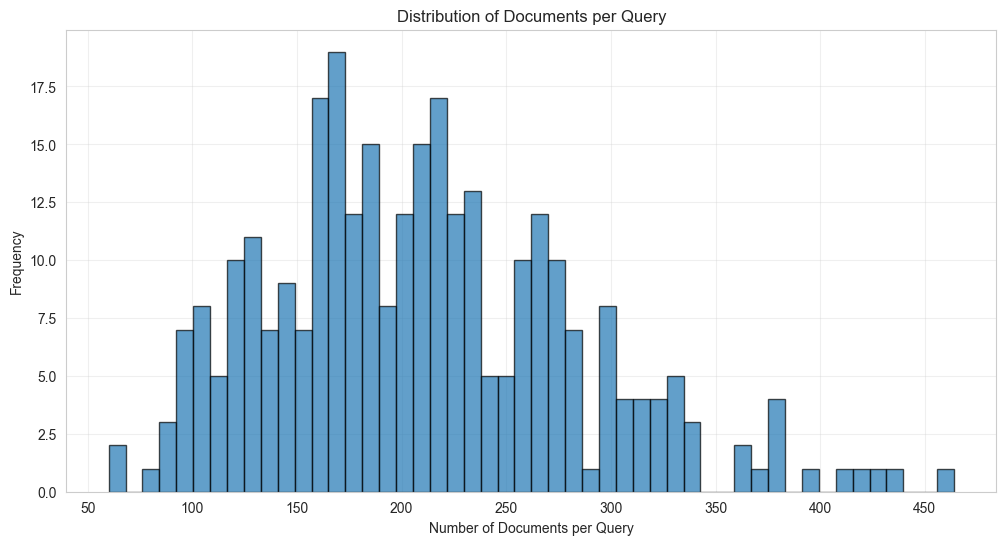

In [70]:
# 1. Histogram: Documents per query
plt.figure(figsize=(12, 6))
plt.hist(docs_per_query['document_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Documents per Query')
plt.ylabel('Frequency')
plt.title('Distribution of Documents per Query')
plt.grid(True, alpha=0.3)
plt.show()


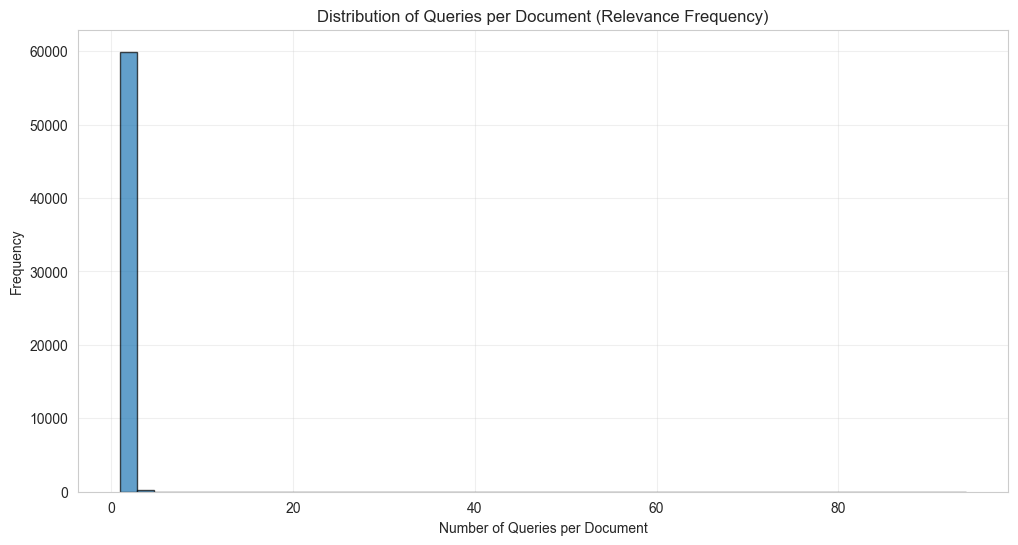

In [71]:
# 2. Histogram: Queries per document (relevance frequency)
plt.figure(figsize=(12, 6))
plt.hist(queries_per_doc['query_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Queries per Document')
plt.ylabel('Frequency')
plt.title('Distribution of Queries per Document (Relevance Frequency)')
plt.grid(True, alpha=0.3)
plt.show()


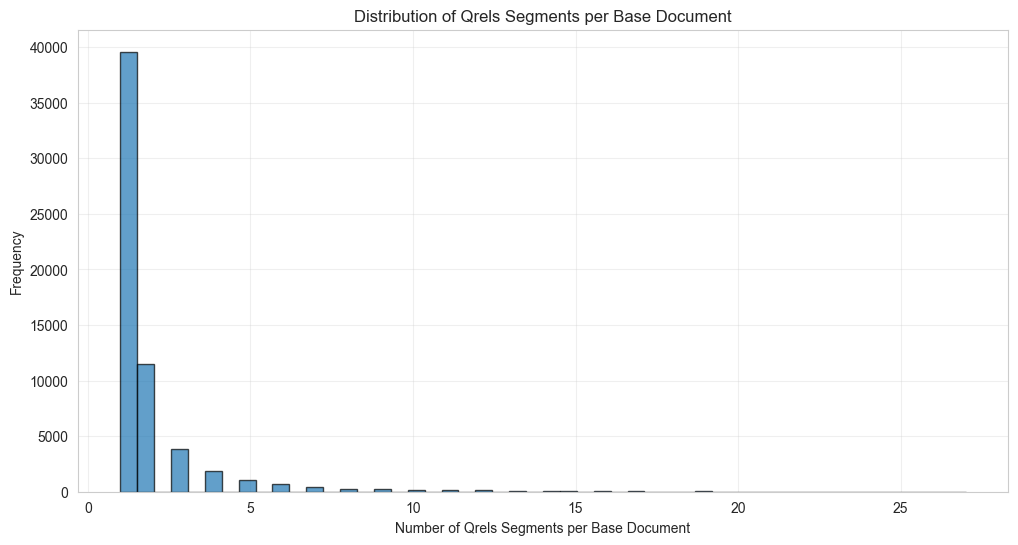

In [72]:
# 3. Histogram: Qrels segments per base document
plt.figure(figsize=(12, 6))
plt.hist(segments_per_doc['qrels_segment_count'], bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Qrels Segments per Base Document')
plt.ylabel('Frequency')
plt.title('Distribution of Qrels Segments per Base Document')
plt.grid(True, alpha=0.3)
plt.show()


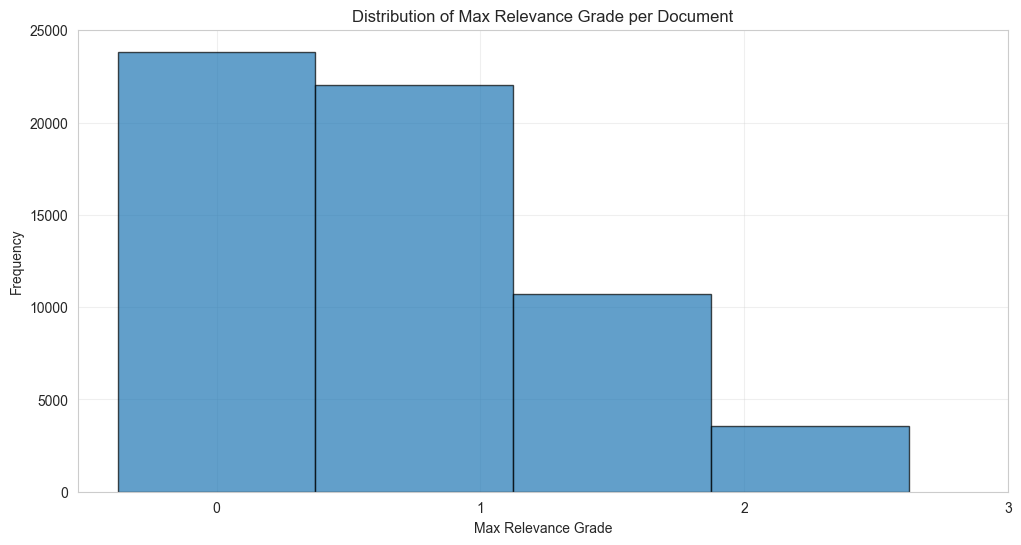

In [73]:
# 4. Histogram: Max relevance grade per document
plt.figure(figsize=(12, 6))
plt.hist(doc_relevance['max_relevance'], bins=4, edgecolor='black', alpha=0.7, align='left')
plt.xlabel('Max Relevance Grade')
plt.ylabel('Frequency')
plt.title('Distribution of Max Relevance Grade per Document')
plt.xticks([0, 1, 2, 3])
plt.grid(True, alpha=0.3)
plt.show()


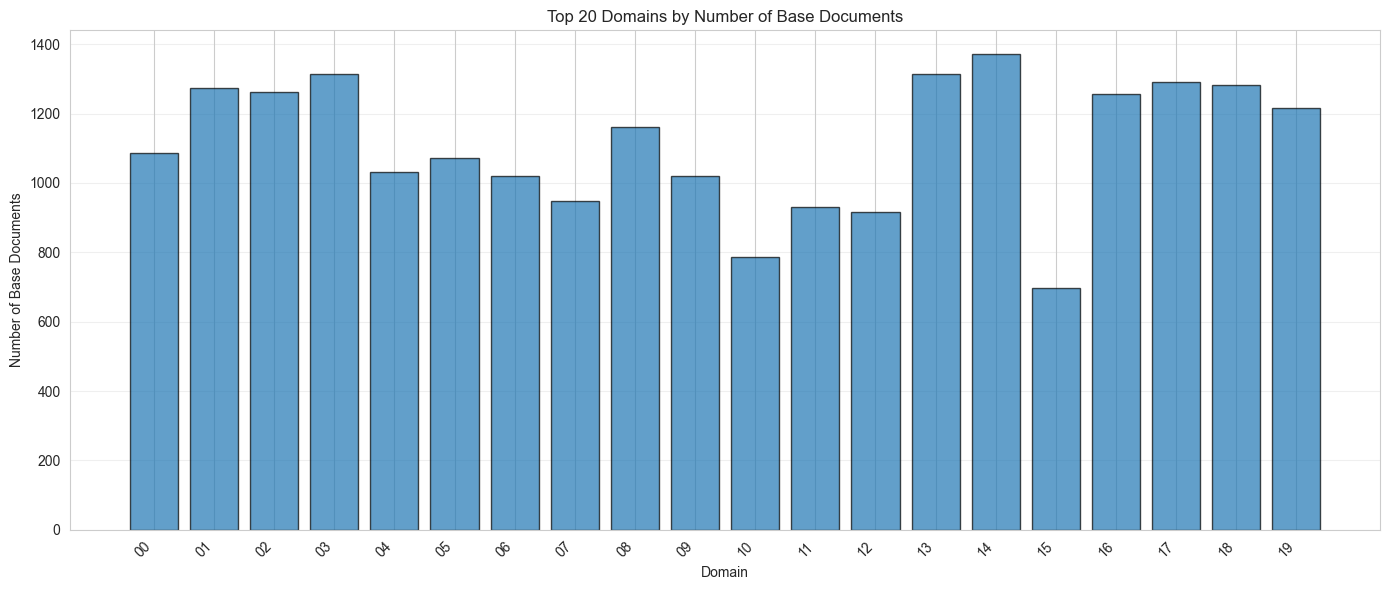

In [74]:
# 5. Bar chart: Domain distribution (base documents)
top_domains = domain_dist.head(20)
plt.figure(figsize=(14, 6))
plt.bar(range(len(top_domains)), top_domains.values, edgecolor='black', alpha=0.7)
plt.xlabel('Domain')
plt.ylabel('Number of Base Documents')
plt.title('Top 20 Domains by Number of Base Documents')
plt.xticks(range(len(top_domains)), top_domains.index, rotation=45, ha='right')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()


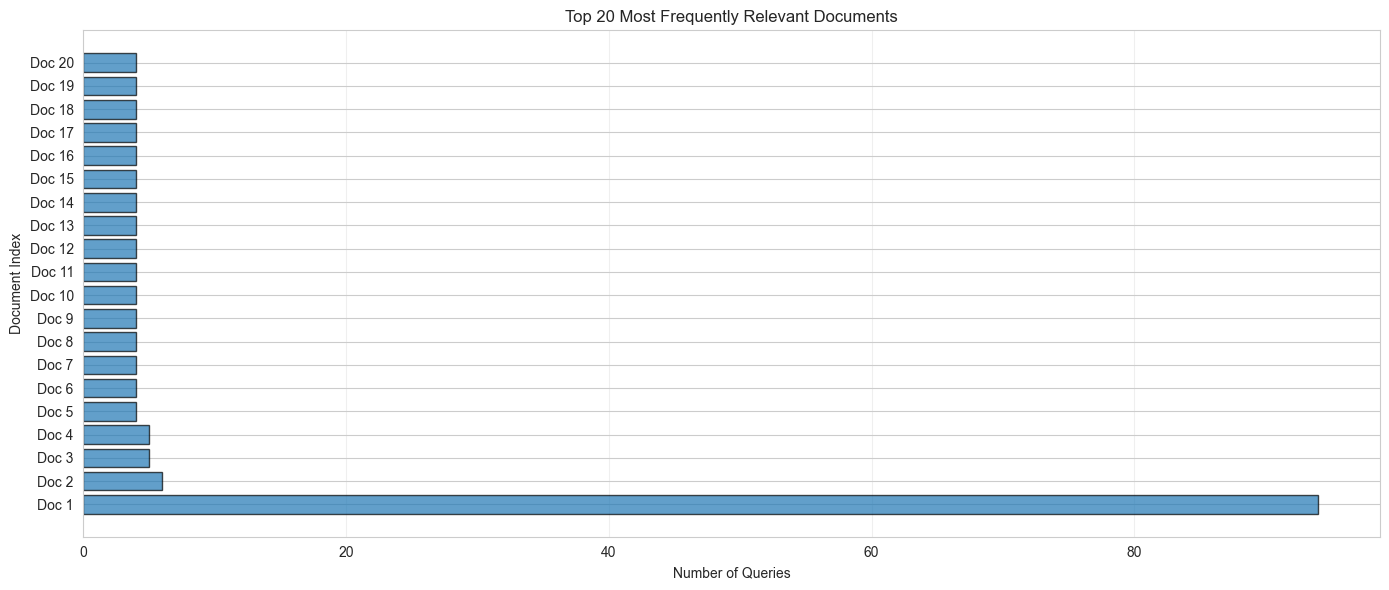

In [75]:
# 6. Bar chart: Top N most frequently relevant documents
top_20_docs = queries_per_doc.nlargest(20, 'query_count')
plt.figure(figsize=(14, 6))
plt.barh(range(len(top_20_docs)), top_20_docs['query_count'].values, edgecolor='black', alpha=0.7)
plt.xlabel('Number of Queries')
plt.ylabel('Document Index')
plt.title('Top 20 Most Frequently Relevant Documents')
plt.yticks(range(len(top_20_docs)), [f"Doc {i+1}" for i in range(len(top_20_docs))])
plt.grid(True, alpha=0.3, axis='x')
plt.tight_layout()
plt.show()


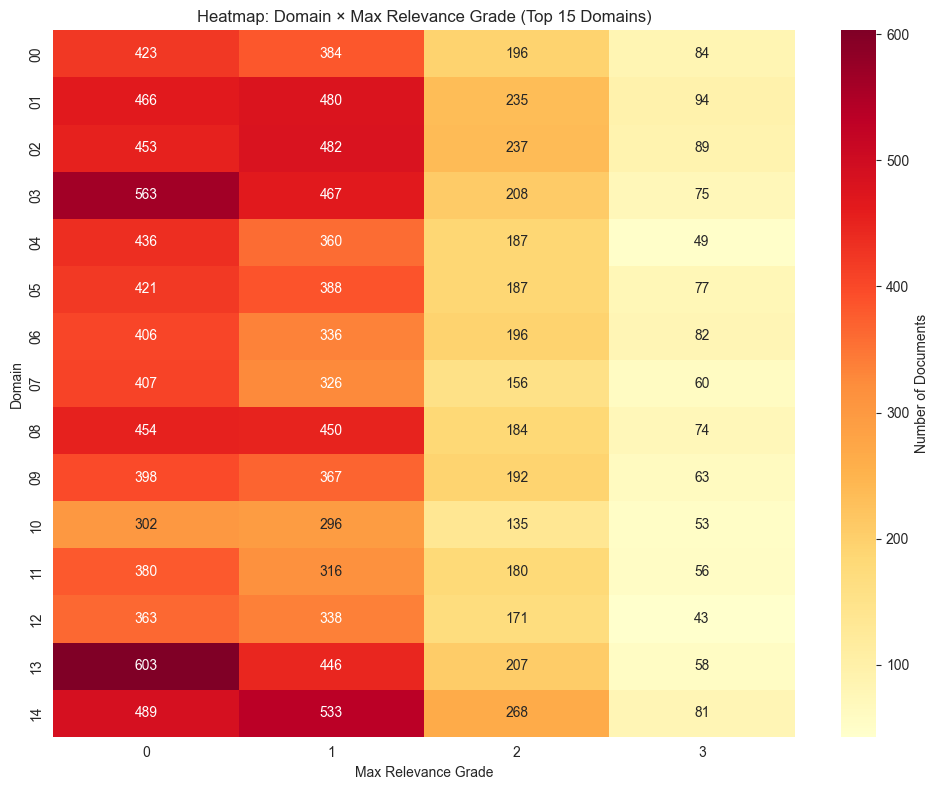

In [76]:
# 7. Heatmap: Domain × Max relevance grade
doc_domain_relevance = qrels_df.groupby('base_doc_id').agg({
    'domain': 'first',
    'relevance': 'max'
}).reset_index()
doc_domain_relevance.columns = ['base_doc_id', 'domain', 'max_relevance']

# Create pivot table
heatmap_data = doc_domain_relevance.groupby(['domain', 'max_relevance']).size().unstack(fill_value=0)

# Select top domains
top_domains_list = domain_dist.head(15).index.tolist()
heatmap_data = heatmap_data.loc[heatmap_data.index.isin(top_domains_list)]

plt.figure(figsize=(10, 8))
sns.heatmap(heatmap_data, annot=True, fmt='d', cmap='YlOrRd', cbar_kws={'label': 'Number of Documents'})
plt.xlabel('Max Relevance Grade')
plt.ylabel('Domain')
plt.title('Heatmap: Domain × Max Relevance Grade (Top 15 Domains)')
plt.tight_layout()
plt.show()


## Section 10: Summary and Recommendations


In [77]:
# Create summary DataFrame with mandatory documents
mandatory_docs_summary = pd.DataFrame({
    'base_doc_id': list(mandatory_base_docs)
})

# Add metadata
mandatory_docs_summary = mandatory_docs_summary.merge(
    queries_per_doc, on='base_doc_id', how='left'
).merge(
    doc_relevance, on='base_doc_id', how='left'
).merge(
    segments_per_doc, on='base_doc_id', how='left'
)

# Add domain
doc_domain = qrels_df.groupby('base_doc_id')['domain'].first().reset_index()
mandatory_docs_summary = mandatory_docs_summary.merge(doc_domain, on='base_doc_id', how='left')

# Sort by query count and max relevance
mandatory_docs_summary = mandatory_docs_summary.sort_values(
    ['query_count', 'max_relevance'], ascending=[False, False]
).reset_index(drop=True)

print("Mandatory Documents Summary:")
print(mandatory_docs_summary.head(10))
print(f"\nTotal mandatory documents: {len(mandatory_docs_summary):,}")


Mandatory Documents Summary:
                      base_doc_id  query_count  max_relevance  avg_relevance  \
0          msmarco_v2.1_doc_01_23           94              1       0.010638   
1  msmarco_v2.1_doc_47_1307014819            6              2       1.125000   
2  msmarco_v2.1_doc_26_1738424403            5              2       0.800000   
3  msmarco_v2.1_doc_41_1691097616            5              2       1.461538   
4  msmarco_v2.1_doc_34_1636826970            4              3       2.066667   
5    msmarco_v2.1_doc_51_56496611            4              3       1.200000   
6  msmarco_v2.1_doc_20_1076942216            4              3       1.714286   
7   msmarco_v2.1_doc_47_571374193            4              3       2.000000   
8  msmarco_v2.1_doc_20_1449387181            4              3       0.785714   
9   msmarco_v2.1_doc_51_880750803            4              3       1.214286   

   qrels_segment_count domain  
0                    1     01  
1                    4    

In [78]:
# Export mandatory base document IDs to CSV
output_file = OUTPUT_DIR / "mandatory_base_documents.csv"
mandatory_docs_summary.to_csv(output_file, index=False)
print(f"\n✓ Exported mandatory base document IDs to: {output_file}")
print(f"  Total documents: {len(mandatory_docs_summary):,}")
print(f"  Columns: {', '.join(mandatory_docs_summary.columns.tolist())}")



✓ Exported mandatory base document IDs to: data/mandatory_base_documents.csv
  Total documents: 60,166
  Columns: base_doc_id, query_count, max_relevance, avg_relevance, qrels_segment_count, domain


In [79]:
print("=" * 60)
print("FINAL SUMMARY")
print("=" * 60)

print(f"\nEssential Findings:")
print(f"  Total required base documents: {len(mandatory_base_docs):,}")
print(f"  Total qrels segments: {len(mandatory_segments):,}")
print(f"  Total queries: {qrels_df['query_id'].nunique():,}")
print(f"  Total domains: {qrels_df['domain'].nunique():,}")

print(f"\nDistribution Characteristics:")
print(f"  Mean documents per query: {docs_per_query['document_count'].mean():.2f}")
print(f"  Mean queries per document: {queries_per_doc['query_count'].mean():.2f}")
print(f"  Mean qrels segments per document: {segments_per_doc['qrels_segment_count'].mean():.2f}")

print(f"\nRelevance Frequency Patterns:")
print(f"  Documents in 1 query: {query_count_dist.get(1, 0):,} ({query_count_dist.get(1, 0)/len(queries_per_doc)*100:.1f}%)")
print(f"  Documents in 2+ queries: {len(queries_per_doc[queries_per_doc['query_count'] >= 2]):,} ({len(queries_per_doc[queries_per_doc['query_count'] >= 2])/len(queries_per_doc)*100:.1f}%)")
print(f"  Documents with max relevance 2-3: {len(doc_relevance[doc_relevance['max_relevance'] >= 2]):,} ({len(doc_relevance[doc_relevance['max_relevance'] >= 2])/len(doc_relevance)*100:.1f}%)")

print(f"\nRecommendations:")
print(f"  Mandatory: All {len(mandatory_base_docs):,} base documents (entire documents)")
print(f"  Optional: Additional documents with no qrels segments (stratify sample)")
print(f"  Ingestion strategy: Document-based (include entire documents)")
print(f"  Minimum dataset size: {len(mandatory_base_docs):,} base documents")

print(f"\n✓ Analysis complete!")
print(f"  CSV file saved to: {output_file}")


FINAL SUMMARY

Essential Findings:
  Total required base documents: 60,166
  Total qrels segments: 107,132
  Total queries: 301
  Total domains: 60

Distribution Characteristics:
  Mean documents per query: 209.78
  Mean queries per document: 1.05
  Mean qrels segments per document: 1.78

Relevance Frequency Patterns:
  Documents in 1 query: 57,542 (95.6%)
  Documents in 2+ queries: 2,624 (4.4%)
  Documents with max relevance 2-3: 14,284 (23.7%)

Recommendations:
  Mandatory: All 60,166 base documents (entire documents)
  Optional: Additional documents with no qrels segments (stratify sample)
  Ingestion strategy: Document-based (include entire documents)
  Minimum dataset size: 60,166 base documents

✓ Analysis complete!
  CSV file saved to: data/mandatory_base_documents.csv
